In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import re

import sys
sys.path.append("./src/") 

import mnist_data
import plot_utils
import gzip
import importlib

import vae as ve
import matplotlib.pyplot as plt



In [85]:
importlib.reload(ve)

filelists = ['IXIC']
mergeddata = ve.readData(filelists)

np_train = mergeddata[0][0]
np_test = mergeddata[0][1]
df_train = mergeddata[0][2]
df_test = mergeddata[0][3]
print(np_train.shape,np_test.shape,df_train.shape,df_test.shape)
np_merged_train = np.vstack([_mergeddt[0] for _i,_mergeddt in enumerate(mergeddata)])
print(np_merged_train.shape)

# df_merged_train = np.vstack([_mergeddt[2]['CloseOrg'].values for _i,_mergeddt in enumerate(mergeddata)])
# df_merged_train.shape

(2082, 4083) (893, 4083) (2082, 29) (893, 29)
(2082, 4083)


### reassemble open,high,low,close, open

In [86]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


In [87]:
new_df_train = []
period = 120

df_train_close = MinMaxScaler(df_train['CloseOrg'])

for i in range(0,df_train.shape[0]//period*period,period):
    new_df_train.append(df_train_close[i:i+period].values)
#     print(df_train['CloseOrg'][i:i+120].shape)
#     print(df_train['CloseOrg'][i:i+120].tail())
#     new_df_train.append(df_train['CloseOrg'][i:i+120])

new_df_train = np.array(new_df_train)
new_df_train.shape

# new_df_train[0]

(17, 120)

<IPython.core.display.Javascript object>


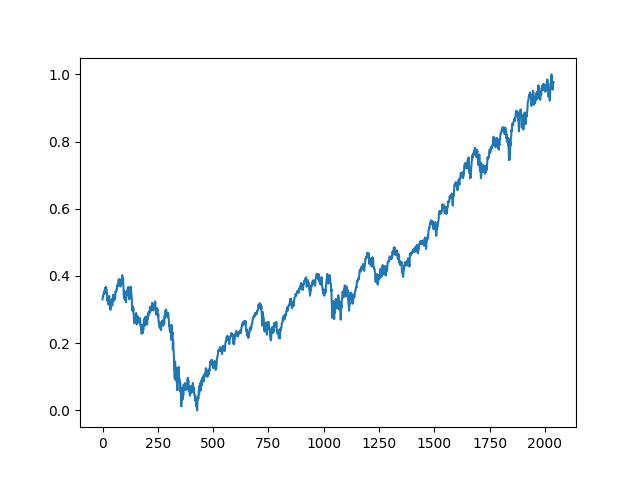

In [88]:
%matplotlib notebook

decode_y = np.array([])
for i in range(new_df_train.shape[0]):
    np_tmp = np.array(new_df_train[i])
    
    decode_y = np.concatenate((decode_y,np_tmp),axis=None)

decode_y.shape
decode_y[:10]
plt.plot(decode_y)

### train network

In [89]:
%matplotlib notebook 
import copy 

importlib.reload(ve)

tf.reset_default_graph() 

with tf.Session() as sess:
        
    learning_rate= 1e-3
    dense_layers = [100,100]
    dense_funcs = ['elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = new_df_train.shape[1]
    
    
    autoencoder = ve.vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    sess.run(tf.global_variables_initializer(), feed_dict={autoencoder.keep_prob : 0.9})
    
    # train
    n_epochs = 5000
    batch_size = 2#128
    n_samples = new_df_train.shape[0]#np_train.shape[0]
    total_batch = int(n_samples / batch_size)
    ADD_NOISE = False
    train_total_data = copy.deepcopy(new_df_train)#np_train
    
#     print("total_batch {}".format(total_batch))
    
    for epoch in range(n_epochs):

        # Random shuffling
        np.random.shuffle(train_total_data)
        train_data_ = train_total_data
#         train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS] # (n_samples,784)
        
        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]
#             print("batch_xs_input {}".format(batch_xs_input.shape))
            batch_xs_target = batch_xs_input
#             print("batch_xs_target {}".format(batch_xs_target[0][:5]))
            
            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)
            
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (autoencoder.train_op, autoencoder.loss, autoencoder.neg_marginal_likelihood, autoencoder.KL_divergence),
                feed_dict={autoencoder.x_hat: batch_xs_input, autoencoder.x: batch_xs_target, autoencoder.keep_prob : 0.9})
            
        
#         print("epoch {}".format(epoch))
        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))
        
        
    autoencoder.save(1)

encoder_dense_layers [100, 100, 2]
elu
tanh
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [100, 100, 120]
tanh
elu
decoder output y:(?, 120)
tanh
elu
epoch 0: L_tot 88.42 L_likelihood 87.00 L_divergence 1.42
epoch 1: L_tot 89.35 L_likelihood 87.28 L_divergence 2.07
epoch 2: L_tot 85.86 L_likelihood 82.57 L_divergence 3.29
epoch 3: L_tot 86.52 L_likelihood 84.92 L_divergence 1.60
epoch 4: L_tot 81.84 L_likelihood 79.22 L_divergence 2.62
epoch 5: L_tot 82.97 L_likelihood 82.08 L_divergence 0.90
epoch 6: L_tot 84.04 L_likelihood 83.09 L_divergence 0.95
epoch 7: L_tot 84.40 L_likelihood 82.51 L_divergence 1.89
epoch 8: L_tot 75.82 L_likelihood 73.37 L_divergence 2.45
epoch 9: L_tot 84.69 L_likelihood 82.64 L_divergence 2.05
epoch 10: L_tot 64.52 L_likelihood 62.48 L_divergence 2.05
epoch 11: L_tot 70.99 L_likelihood 69.89 L_divergence 1.11
epoch 12: L_tot 81.45 L_likelihood 79.51 L_divergence 1.94
epoch 13: L_tot 74.30 L_likelihood 71.95 

epoch 138: L_tot 67.68 L_likelihood 64.83 L_divergence 2.85
epoch 139: L_tot 75.31 L_likelihood 73.88 L_divergence 1.43
epoch 140: L_tot 61.66 L_likelihood 57.92 L_divergence 3.74
epoch 141: L_tot 86.30 L_likelihood 84.15 L_divergence 2.14
epoch 142: L_tot 42.93 L_likelihood 39.05 L_divergence 3.87
epoch 143: L_tot 60.90 L_likelihood 58.25 L_divergence 2.65
epoch 144: L_tot 59.71 L_likelihood 56.76 L_divergence 2.95
epoch 145: L_tot 83.67 L_likelihood 82.42 L_divergence 1.25
epoch 146: L_tot 65.50 L_likelihood 63.04 L_divergence 2.46
epoch 147: L_tot 94.63 L_likelihood 92.71 L_divergence 1.93
epoch 148: L_tot 59.62 L_likelihood 56.89 L_divergence 2.73
epoch 149: L_tot 63.21 L_likelihood 60.49 L_divergence 2.72
epoch 150: L_tot 77.84 L_likelihood 76.36 L_divergence 1.48
epoch 151: L_tot 83.29 L_likelihood 81.98 L_divergence 1.31
epoch 152: L_tot 61.03 L_likelihood 58.07 L_divergence 2.95
epoch 153: L_tot 81.82 L_likelihood 79.72 L_divergence 2.10
epoch 154: L_tot 54.20 L_likelihood 51.2

epoch 287: L_tot 85.94 L_likelihood 84.42 L_divergence 1.52
epoch 288: L_tot 79.03 L_likelihood 77.52 L_divergence 1.52
epoch 289: L_tot 70.25 L_likelihood 69.24 L_divergence 1.01
epoch 290: L_tot 69.30 L_likelihood 66.37 L_divergence 2.93
epoch 291: L_tot 82.25 L_likelihood 80.39 L_divergence 1.86
epoch 292: L_tot 80.76 L_likelihood 79.38 L_divergence 1.38
epoch 293: L_tot 54.53 L_likelihood 51.08 L_divergence 3.45
epoch 294: L_tot 82.33 L_likelihood 80.80 L_divergence 1.53
epoch 295: L_tot 75.29 L_likelihood 73.84 L_divergence 1.45
epoch 296: L_tot 82.38 L_likelihood 81.14 L_divergence 1.24
epoch 297: L_tot 71.77 L_likelihood 69.95 L_divergence 1.81
epoch 298: L_tot 78.35 L_likelihood 76.69 L_divergence 1.67
epoch 299: L_tot 81.01 L_likelihood 79.95 L_divergence 1.06
epoch 300: L_tot 60.02 L_likelihood 57.72 L_divergence 2.29
epoch 301: L_tot 90.47 L_likelihood 89.12 L_divergence 1.35
epoch 302: L_tot 65.58 L_likelihood 61.32 L_divergence 4.26
epoch 303: L_tot 73.73 L_likelihood 71.5

epoch 428: L_tot 80.78 L_likelihood 79.47 L_divergence 1.30
epoch 429: L_tot 49.33 L_likelihood 46.80 L_divergence 2.52
epoch 430: L_tot 57.96 L_likelihood 56.18 L_divergence 1.78
epoch 431: L_tot 70.45 L_likelihood 69.52 L_divergence 0.93
epoch 432: L_tot 79.26 L_likelihood 78.20 L_divergence 1.07
epoch 433: L_tot 55.26 L_likelihood 53.01 L_divergence 2.25
epoch 434: L_tot 79.34 L_likelihood 78.20 L_divergence 1.15
epoch 435: L_tot 71.88 L_likelihood 70.29 L_divergence 1.59
epoch 436: L_tot 59.07 L_likelihood 56.47 L_divergence 2.60
epoch 437: L_tot 63.73 L_likelihood 61.17 L_divergence 2.56
epoch 438: L_tot 82.62 L_likelihood 81.25 L_divergence 1.37
epoch 439: L_tot 66.44 L_likelihood 64.77 L_divergence 1.67
epoch 440: L_tot 35.97 L_likelihood 31.96 L_divergence 4.00
epoch 441: L_tot 76.76 L_likelihood 75.37 L_divergence 1.39
epoch 442: L_tot 50.74 L_likelihood 47.80 L_divergence 2.95
epoch 443: L_tot 67.40 L_likelihood 65.43 L_divergence 1.98
epoch 444: L_tot 74.80 L_likelihood 73.0

epoch 573: L_tot 50.06 L_likelihood 46.87 L_divergence 3.18
epoch 574: L_tot 64.84 L_likelihood 62.95 L_divergence 1.89
epoch 575: L_tot 53.05 L_likelihood 50.27 L_divergence 2.78
epoch 576: L_tot 52.22 L_likelihood 49.90 L_divergence 2.32
epoch 577: L_tot 68.41 L_likelihood 66.36 L_divergence 2.05
epoch 578: L_tot 73.91 L_likelihood 72.80 L_divergence 1.11
epoch 579: L_tot 74.17 L_likelihood 71.35 L_divergence 2.82
epoch 580: L_tot 73.23 L_likelihood 71.34 L_divergence 1.89
epoch 581: L_tot 81.76 L_likelihood 80.03 L_divergence 1.73
epoch 582: L_tot 58.25 L_likelihood 55.78 L_divergence 2.46
epoch 583: L_tot 86.54 L_likelihood 84.31 L_divergence 2.23
epoch 584: L_tot 53.22 L_likelihood 51.02 L_divergence 2.20
epoch 585: L_tot 70.87 L_likelihood 69.50 L_divergence 1.37
epoch 586: L_tot 82.18 L_likelihood 80.73 L_divergence 1.44
epoch 587: L_tot 80.50 L_likelihood 79.02 L_divergence 1.48
epoch 588: L_tot 74.86 L_likelihood 72.35 L_divergence 2.51
epoch 589: L_tot 76.40 L_likelihood 74.9

epoch 720: L_tot 80.97 L_likelihood 79.38 L_divergence 1.59
epoch 721: L_tot 75.37 L_likelihood 72.70 L_divergence 2.67
epoch 722: L_tot 63.58 L_likelihood 60.98 L_divergence 2.60
epoch 723: L_tot 50.73 L_likelihood 47.76 L_divergence 2.97
epoch 724: L_tot 59.12 L_likelihood 56.82 L_divergence 2.31
epoch 725: L_tot 75.90 L_likelihood 74.21 L_divergence 1.69
epoch 726: L_tot 75.34 L_likelihood 74.19 L_divergence 1.15
epoch 727: L_tot 62.26 L_likelihood 60.34 L_divergence 1.92
epoch 728: L_tot 77.39 L_likelihood 76.69 L_divergence 0.70
epoch 729: L_tot 79.63 L_likelihood 78.57 L_divergence 1.07
epoch 730: L_tot 74.10 L_likelihood 72.95 L_divergence 1.15
epoch 731: L_tot 73.55 L_likelihood 72.40 L_divergence 1.15
epoch 732: L_tot 81.39 L_likelihood 79.90 L_divergence 1.49
epoch 733: L_tot 66.92 L_likelihood 64.78 L_divergence 2.13
epoch 734: L_tot 72.99 L_likelihood 71.74 L_divergence 1.25
epoch 735: L_tot 45.35 L_likelihood 42.45 L_divergence 2.90
epoch 736: L_tot 60.91 L_likelihood 59.1

epoch 867: L_tot 81.40 L_likelihood 79.74 L_divergence 1.66
epoch 868: L_tot 54.66 L_likelihood 52.14 L_divergence 2.52
epoch 869: L_tot 44.27 L_likelihood 41.71 L_divergence 2.56
epoch 870: L_tot 53.87 L_likelihood 51.74 L_divergence 2.13
epoch 871: L_tot 66.00 L_likelihood 64.62 L_divergence 1.38
epoch 872: L_tot 63.90 L_likelihood 61.80 L_divergence 2.11
epoch 873: L_tot 75.57 L_likelihood 73.05 L_divergence 2.52
epoch 874: L_tot 70.61 L_likelihood 68.64 L_divergence 1.97
epoch 875: L_tot 75.14 L_likelihood 73.38 L_divergence 1.76
epoch 876: L_tot 48.53 L_likelihood 46.09 L_divergence 2.44
epoch 877: L_tot 65.76 L_likelihood 64.44 L_divergence 1.32
epoch 878: L_tot 83.65 L_likelihood 82.20 L_divergence 1.45
epoch 879: L_tot 76.73 L_likelihood 75.25 L_divergence 1.48
epoch 880: L_tot 69.39 L_likelihood 67.49 L_divergence 1.91
epoch 881: L_tot 77.77 L_likelihood 76.31 L_divergence 1.46
epoch 882: L_tot 82.37 L_likelihood 80.90 L_divergence 1.47
epoch 883: L_tot 77.77 L_likelihood 76.0

epoch 1013: L_tot 83.12 L_likelihood 81.88 L_divergence 1.24
epoch 1014: L_tot 72.65 L_likelihood 71.41 L_divergence 1.24
epoch 1015: L_tot 74.84 L_likelihood 73.94 L_divergence 0.90
epoch 1016: L_tot 54.85 L_likelihood 52.12 L_divergence 2.73
epoch 1017: L_tot 79.78 L_likelihood 78.80 L_divergence 0.98
epoch 1018: L_tot 63.33 L_likelihood 61.06 L_divergence 2.28
epoch 1019: L_tot 68.07 L_likelihood 65.89 L_divergence 2.17
epoch 1020: L_tot 72.80 L_likelihood 71.36 L_divergence 1.43
epoch 1021: L_tot 83.14 L_likelihood 82.05 L_divergence 1.09
epoch 1022: L_tot 78.55 L_likelihood 77.39 L_divergence 1.16
epoch 1023: L_tot 82.56 L_likelihood 81.27 L_divergence 1.29
epoch 1024: L_tot 80.40 L_likelihood 79.10 L_divergence 1.30
epoch 1025: L_tot 65.10 L_likelihood 63.17 L_divergence 1.93
epoch 1026: L_tot 79.81 L_likelihood 78.75 L_divergence 1.06
epoch 1027: L_tot 78.40 L_likelihood 76.56 L_divergence 1.84
epoch 1028: L_tot 86.98 L_likelihood 85.30 L_divergence 1.69
epoch 1029: L_tot 69.31 

epoch 1156: L_tot 71.20 L_likelihood 70.10 L_divergence 1.10
epoch 1157: L_tot 79.14 L_likelihood 78.05 L_divergence 1.09
epoch 1158: L_tot 59.55 L_likelihood 56.96 L_divergence 2.59
epoch 1159: L_tot 81.82 L_likelihood 80.60 L_divergence 1.22
epoch 1160: L_tot 82.05 L_likelihood 80.77 L_divergence 1.27
epoch 1161: L_tot 74.48 L_likelihood 72.73 L_divergence 1.75
epoch 1162: L_tot 56.56 L_likelihood 54.41 L_divergence 2.15
epoch 1163: L_tot 63.43 L_likelihood 61.91 L_divergence 1.52
epoch 1164: L_tot 72.69 L_likelihood 71.20 L_divergence 1.50
epoch 1165: L_tot 52.81 L_likelihood 50.47 L_divergence 2.34
epoch 1166: L_tot 75.37 L_likelihood 73.71 L_divergence 1.66
epoch 1167: L_tot 63.26 L_likelihood 59.96 L_divergence 3.30
epoch 1168: L_tot 57.22 L_likelihood 55.35 L_divergence 1.87
epoch 1169: L_tot 74.94 L_likelihood 73.23 L_divergence 1.71
epoch 1170: L_tot 82.76 L_likelihood 80.98 L_divergence 1.78
epoch 1171: L_tot 80.27 L_likelihood 79.18 L_divergence 1.09
epoch 1172: L_tot 64.28 

epoch 1301: L_tot 52.59 L_likelihood 50.34 L_divergence 2.24
epoch 1302: L_tot 71.49 L_likelihood 70.05 L_divergence 1.43
epoch 1303: L_tot 81.06 L_likelihood 79.87 L_divergence 1.19
epoch 1304: L_tot 70.95 L_likelihood 69.60 L_divergence 1.35
epoch 1305: L_tot 58.36 L_likelihood 56.15 L_divergence 2.22
epoch 1306: L_tot 77.71 L_likelihood 75.98 L_divergence 1.73
epoch 1307: L_tot 48.27 L_likelihood 46.23 L_divergence 2.04
epoch 1308: L_tot 82.83 L_likelihood 81.55 L_divergence 1.28
epoch 1309: L_tot 72.61 L_likelihood 71.02 L_divergence 1.60
epoch 1310: L_tot 79.60 L_likelihood 78.49 L_divergence 1.11
epoch 1311: L_tot 76.22 L_likelihood 74.92 L_divergence 1.30
epoch 1312: L_tot 85.24 L_likelihood 83.62 L_divergence 1.62
epoch 1313: L_tot 84.46 L_likelihood 82.34 L_divergence 2.12
epoch 1314: L_tot 64.32 L_likelihood 62.04 L_divergence 2.28
epoch 1315: L_tot 70.97 L_likelihood 69.74 L_divergence 1.23
epoch 1316: L_tot 72.48 L_likelihood 71.14 L_divergence 1.33
epoch 1317: L_tot 78.96 

epoch 1437: L_tot 75.05 L_likelihood 73.26 L_divergence 1.78
epoch 1438: L_tot 55.39 L_likelihood 53.46 L_divergence 1.93
epoch 1439: L_tot 55.04 L_likelihood 52.79 L_divergence 2.26
epoch 1440: L_tot 38.14 L_likelihood 35.41 L_divergence 2.73
epoch 1441: L_tot 82.14 L_likelihood 80.88 L_divergence 1.26
epoch 1442: L_tot 77.19 L_likelihood 75.86 L_divergence 1.33
epoch 1443: L_tot 83.30 L_likelihood 81.72 L_divergence 1.58
epoch 1444: L_tot 76.70 L_likelihood 74.76 L_divergence 1.94
epoch 1445: L_tot 64.47 L_likelihood 63.20 L_divergence 1.26
epoch 1446: L_tot 73.83 L_likelihood 72.56 L_divergence 1.26
epoch 1447: L_tot 72.99 L_likelihood 71.36 L_divergence 1.63
epoch 1448: L_tot 71.40 L_likelihood 70.06 L_divergence 1.33
epoch 1449: L_tot 79.05 L_likelihood 78.05 L_divergence 1.01
epoch 1450: L_tot 73.30 L_likelihood 71.77 L_divergence 1.53
epoch 1451: L_tot 63.58 L_likelihood 61.43 L_divergence 2.14
epoch 1452: L_tot 69.85 L_likelihood 68.03 L_divergence 1.82
epoch 1453: L_tot 78.67 

epoch 1573: L_tot 53.26 L_likelihood 51.06 L_divergence 2.20
epoch 1574: L_tot 69.78 L_likelihood 66.96 L_divergence 2.82
epoch 1575: L_tot 72.09 L_likelihood 70.75 L_divergence 1.34
epoch 1576: L_tot 64.19 L_likelihood 62.21 L_divergence 1.98
epoch 1577: L_tot 74.95 L_likelihood 73.79 L_divergence 1.16
epoch 1578: L_tot 85.48 L_likelihood 83.92 L_divergence 1.56
epoch 1579: L_tot 71.75 L_likelihood 70.21 L_divergence 1.54
epoch 1580: L_tot 85.92 L_likelihood 84.35 L_divergence 1.57
epoch 1581: L_tot 78.40 L_likelihood 76.88 L_divergence 1.52
epoch 1582: L_tot 81.25 L_likelihood 79.93 L_divergence 1.32
epoch 1583: L_tot 78.67 L_likelihood 77.24 L_divergence 1.44
epoch 1584: L_tot 81.05 L_likelihood 79.89 L_divergence 1.16
epoch 1585: L_tot 82.87 L_likelihood 81.69 L_divergence 1.18
epoch 1586: L_tot 73.96 L_likelihood 72.25 L_divergence 1.70
epoch 1587: L_tot 71.38 L_likelihood 69.94 L_divergence 1.44
epoch 1588: L_tot 61.94 L_likelihood 60.13 L_divergence 1.81
epoch 1589: L_tot 38.34 

epoch 1710: L_tot 80.15 L_likelihood 79.02 L_divergence 1.13
epoch 1711: L_tot 76.30 L_likelihood 74.55 L_divergence 1.75
epoch 1712: L_tot 69.11 L_likelihood 67.80 L_divergence 1.31
epoch 1713: L_tot 86.09 L_likelihood 84.17 L_divergence 1.92
epoch 1714: L_tot 57.79 L_likelihood 55.86 L_divergence 1.93
epoch 1715: L_tot 32.67 L_likelihood 29.71 L_divergence 2.96
epoch 1716: L_tot 55.01 L_likelihood 52.37 L_divergence 2.64
epoch 1717: L_tot 64.09 L_likelihood 62.27 L_divergence 1.83
epoch 1718: L_tot 61.02 L_likelihood 58.82 L_divergence 2.19
epoch 1719: L_tot 74.42 L_likelihood 73.33 L_divergence 1.09
epoch 1720: L_tot 83.90 L_likelihood 82.73 L_divergence 1.16
epoch 1721: L_tot 66.46 L_likelihood 64.75 L_divergence 1.72
epoch 1722: L_tot 63.45 L_likelihood 61.74 L_divergence 1.71
epoch 1723: L_tot 79.56 L_likelihood 78.51 L_divergence 1.04
epoch 1724: L_tot 76.48 L_likelihood 75.26 L_divergence 1.22
epoch 1725: L_tot 71.84 L_likelihood 70.30 L_divergence 1.53
epoch 1726: L_tot 58.74 

epoch 1857: L_tot 80.21 L_likelihood 79.07 L_divergence 1.14
epoch 1858: L_tot 67.99 L_likelihood 66.51 L_divergence 1.48
epoch 1859: L_tot 65.25 L_likelihood 63.62 L_divergence 1.63
epoch 1860: L_tot 75.54 L_likelihood 73.86 L_divergence 1.68
epoch 1861: L_tot 71.97 L_likelihood 70.68 L_divergence 1.29
epoch 1862: L_tot 49.59 L_likelihood 47.01 L_divergence 2.58
epoch 1863: L_tot 75.40 L_likelihood 74.16 L_divergence 1.24
epoch 1864: L_tot 70.74 L_likelihood 68.74 L_divergence 2.00
epoch 1865: L_tot 56.09 L_likelihood 53.79 L_divergence 2.30
epoch 1866: L_tot 83.49 L_likelihood 82.43 L_divergence 1.06
epoch 1867: L_tot 74.66 L_likelihood 73.33 L_divergence 1.33
epoch 1868: L_tot 62.37 L_likelihood 60.56 L_divergence 1.80
epoch 1869: L_tot 59.43 L_likelihood 57.00 L_divergence 2.43
epoch 1870: L_tot 76.41 L_likelihood 74.33 L_divergence 2.08
epoch 1871: L_tot 84.55 L_likelihood 82.90 L_divergence 1.65
epoch 1872: L_tot 30.96 L_likelihood 28.02 L_divergence 2.95
epoch 1873: L_tot 59.89 

epoch 1992: L_tot 78.43 L_likelihood 77.20 L_divergence 1.23
epoch 1993: L_tot 71.74 L_likelihood 70.51 L_divergence 1.23
epoch 1994: L_tot 55.83 L_likelihood 53.26 L_divergence 2.57
epoch 1995: L_tot 79.67 L_likelihood 77.72 L_divergence 1.95
epoch 1996: L_tot 64.27 L_likelihood 62.68 L_divergence 1.59
epoch 1997: L_tot 75.12 L_likelihood 73.65 L_divergence 1.47
epoch 1998: L_tot 56.49 L_likelihood 54.13 L_divergence 2.36
epoch 1999: L_tot 82.55 L_likelihood 81.34 L_divergence 1.21
epoch 2000: L_tot 62.86 L_likelihood 60.93 L_divergence 1.93
epoch 2001: L_tot 72.95 L_likelihood 71.22 L_divergence 1.73
epoch 2002: L_tot 83.77 L_likelihood 81.87 L_divergence 1.90
epoch 2003: L_tot 76.28 L_likelihood 74.15 L_divergence 2.13
epoch 2004: L_tot 50.99 L_likelihood 48.94 L_divergence 2.05
epoch 2005: L_tot 80.88 L_likelihood 79.75 L_divergence 1.13
epoch 2006: L_tot 65.03 L_likelihood 63.24 L_divergence 1.79
epoch 2007: L_tot 77.50 L_likelihood 75.88 L_divergence 1.61
epoch 2008: L_tot 75.44 

epoch 2130: L_tot 67.95 L_likelihood 65.86 L_divergence 2.09
epoch 2131: L_tot 78.02 L_likelihood 76.43 L_divergence 1.60
epoch 2132: L_tot 78.14 L_likelihood 76.53 L_divergence 1.61
epoch 2133: L_tot 72.16 L_likelihood 70.90 L_divergence 1.27
epoch 2134: L_tot 78.62 L_likelihood 77.35 L_divergence 1.27
epoch 2135: L_tot 44.96 L_likelihood 42.34 L_divergence 2.62
epoch 2136: L_tot 80.62 L_likelihood 78.73 L_divergence 1.90
epoch 2137: L_tot 75.61 L_likelihood 74.03 L_divergence 1.58
epoch 2138: L_tot 54.17 L_likelihood 52.24 L_divergence 1.94
epoch 2139: L_tot 84.15 L_likelihood 82.90 L_divergence 1.26
epoch 2140: L_tot 80.14 L_likelihood 78.98 L_divergence 1.16
epoch 2141: L_tot 46.93 L_likelihood 44.48 L_divergence 2.46
epoch 2142: L_tot 75.74 L_likelihood 73.83 L_divergence 1.91
epoch 2143: L_tot 76.40 L_likelihood 75.29 L_divergence 1.11
epoch 2144: L_tot 71.31 L_likelihood 70.06 L_divergence 1.26
epoch 2145: L_tot 78.93 L_likelihood 77.61 L_divergence 1.32
epoch 2146: L_tot 62.92 

epoch 2272: L_tot 71.88 L_likelihood 70.40 L_divergence 1.48
epoch 2273: L_tot 80.01 L_likelihood 78.62 L_divergence 1.39
epoch 2274: L_tot 66.87 L_likelihood 65.17 L_divergence 1.70
epoch 2275: L_tot 78.71 L_likelihood 77.57 L_divergence 1.14
epoch 2276: L_tot 46.80 L_likelihood 44.18 L_divergence 2.62
epoch 2277: L_tot 79.25 L_likelihood 78.16 L_divergence 1.08
epoch 2278: L_tot 69.50 L_likelihood 67.96 L_divergence 1.54
epoch 2279: L_tot 58.70 L_likelihood 56.49 L_divergence 2.21
epoch 2280: L_tot 68.90 L_likelihood 66.98 L_divergence 1.91
epoch 2281: L_tot 44.70 L_likelihood 41.94 L_divergence 2.76
epoch 2282: L_tot 44.59 L_likelihood 41.66 L_divergence 2.92
epoch 2283: L_tot 73.24 L_likelihood 71.95 L_divergence 1.29
epoch 2284: L_tot 71.94 L_likelihood 70.47 L_divergence 1.47
epoch 2285: L_tot 68.78 L_likelihood 66.71 L_divergence 2.07
epoch 2286: L_tot 77.00 L_likelihood 75.78 L_divergence 1.22
epoch 2287: L_tot 70.17 L_likelihood 68.19 L_divergence 1.98
epoch 2288: L_tot 70.11 

epoch 2408: L_tot 79.94 L_likelihood 78.59 L_divergence 1.35
epoch 2409: L_tot 77.91 L_likelihood 76.81 L_divergence 1.10
epoch 2410: L_tot 67.92 L_likelihood 65.81 L_divergence 2.10
epoch 2411: L_tot 71.88 L_likelihood 70.45 L_divergence 1.43
epoch 2412: L_tot 56.66 L_likelihood 54.73 L_divergence 1.93
epoch 2413: L_tot 62.93 L_likelihood 60.93 L_divergence 2.00
epoch 2414: L_tot 51.26 L_likelihood 48.77 L_divergence 2.49
epoch 2415: L_tot 71.11 L_likelihood 70.07 L_divergence 1.04
epoch 2416: L_tot 77.54 L_likelihood 75.64 L_divergence 1.90
epoch 2417: L_tot 61.32 L_likelihood 59.12 L_divergence 2.20
epoch 2418: L_tot 76.07 L_likelihood 74.12 L_divergence 1.95
epoch 2419: L_tot 72.46 L_likelihood 70.83 L_divergence 1.63
epoch 2420: L_tot 61.39 L_likelihood 58.90 L_divergence 2.50
epoch 2421: L_tot 65.64 L_likelihood 63.43 L_divergence 2.21
epoch 2422: L_tot 82.98 L_likelihood 81.49 L_divergence 1.49
epoch 2423: L_tot 77.89 L_likelihood 75.67 L_divergence 2.23
epoch 2424: L_tot 82.04 

epoch 2546: L_tot 64.56 L_likelihood 62.69 L_divergence 1.88
epoch 2547: L_tot 71.43 L_likelihood 70.23 L_divergence 1.20
epoch 2548: L_tot 64.44 L_likelihood 62.45 L_divergence 2.00
epoch 2549: L_tot 71.52 L_likelihood 69.41 L_divergence 2.11
epoch 2550: L_tot 73.09 L_likelihood 71.69 L_divergence 1.41
epoch 2551: L_tot 77.78 L_likelihood 76.62 L_divergence 1.16
epoch 2552: L_tot 78.80 L_likelihood 76.91 L_divergence 1.89
epoch 2553: L_tot 70.54 L_likelihood 68.28 L_divergence 2.26
epoch 2554: L_tot 55.37 L_likelihood 53.31 L_divergence 2.07
epoch 2555: L_tot 57.60 L_likelihood 55.50 L_divergence 2.10
epoch 2556: L_tot 76.80 L_likelihood 75.63 L_divergence 1.17
epoch 2557: L_tot 79.48 L_likelihood 77.58 L_divergence 1.90
epoch 2558: L_tot 61.88 L_likelihood 59.32 L_divergence 2.55
epoch 2559: L_tot 82.22 L_likelihood 80.92 L_divergence 1.30
epoch 2560: L_tot 79.81 L_likelihood 78.59 L_divergence 1.22
epoch 2561: L_tot 61.05 L_likelihood 59.24 L_divergence 1.81
epoch 2562: L_tot 75.37 

epoch 2693: L_tot 76.27 L_likelihood 75.08 L_divergence 1.19
epoch 2694: L_tot 66.20 L_likelihood 64.59 L_divergence 1.61
epoch 2695: L_tot 84.40 L_likelihood 82.78 L_divergence 1.62
epoch 2696: L_tot 87.86 L_likelihood 86.53 L_divergence 1.33
epoch 2697: L_tot 61.59 L_likelihood 60.00 L_divergence 1.59
epoch 2698: L_tot 78.07 L_likelihood 77.03 L_divergence 1.03
epoch 2699: L_tot 71.71 L_likelihood 70.22 L_divergence 1.49
epoch 2700: L_tot 67.14 L_likelihood 65.07 L_divergence 2.07
epoch 2701: L_tot 72.06 L_likelihood 70.92 L_divergence 1.14
epoch 2702: L_tot 75.55 L_likelihood 73.59 L_divergence 1.97
epoch 2703: L_tot 77.96 L_likelihood 76.74 L_divergence 1.22
epoch 2704: L_tot 72.24 L_likelihood 71.13 L_divergence 1.11
epoch 2705: L_tot 81.82 L_likelihood 80.62 L_divergence 1.19
epoch 2706: L_tot 80.33 L_likelihood 79.16 L_divergence 1.17
epoch 2707: L_tot 78.52 L_likelihood 77.17 L_divergence 1.35
epoch 2708: L_tot 63.38 L_likelihood 61.36 L_divergence 2.02
epoch 2709: L_tot 66.76 

epoch 2830: L_tot 72.14 L_likelihood 70.63 L_divergence 1.51
epoch 2831: L_tot 70.47 L_likelihood 68.85 L_divergence 1.62
epoch 2832: L_tot 71.88 L_likelihood 70.28 L_divergence 1.59
epoch 2833: L_tot 82.28 L_likelihood 80.66 L_divergence 1.63
epoch 2834: L_tot 55.30 L_likelihood 53.39 L_divergence 1.91
epoch 2835: L_tot 71.34 L_likelihood 69.94 L_divergence 1.40
epoch 2836: L_tot 85.00 L_likelihood 83.65 L_divergence 1.35
epoch 2837: L_tot 57.05 L_likelihood 54.79 L_divergence 2.27
epoch 2838: L_tot 57.38 L_likelihood 55.04 L_divergence 2.34
epoch 2839: L_tot 80.84 L_likelihood 79.08 L_divergence 1.76
epoch 2840: L_tot 60.29 L_likelihood 57.75 L_divergence 2.55
epoch 2841: L_tot 77.13 L_likelihood 74.93 L_divergence 2.20
epoch 2842: L_tot 43.72 L_likelihood 40.76 L_divergence 2.96
epoch 2843: L_tot 30.81 L_likelihood 27.59 L_divergence 3.22
epoch 2844: L_tot 69.29 L_likelihood 67.49 L_divergence 1.80
epoch 2845: L_tot 50.41 L_likelihood 48.36 L_divergence 2.05
epoch 2846: L_tot 79.38 

epoch 2975: L_tot 65.53 L_likelihood 63.62 L_divergence 1.91
epoch 2976: L_tot 72.54 L_likelihood 71.56 L_divergence 0.97
epoch 2977: L_tot 65.68 L_likelihood 63.10 L_divergence 2.58
epoch 2978: L_tot 70.33 L_likelihood 69.06 L_divergence 1.27
epoch 2979: L_tot 58.25 L_likelihood 55.95 L_divergence 2.31
epoch 2980: L_tot 80.84 L_likelihood 79.82 L_divergence 1.02
epoch 2981: L_tot 46.74 L_likelihood 44.06 L_divergence 2.68
epoch 2982: L_tot 72.61 L_likelihood 71.29 L_divergence 1.32
epoch 2983: L_tot 77.36 L_likelihood 75.93 L_divergence 1.44
epoch 2984: L_tot 69.26 L_likelihood 67.28 L_divergence 1.98
epoch 2985: L_tot 83.83 L_likelihood 82.48 L_divergence 1.35
epoch 2986: L_tot 62.22 L_likelihood 60.12 L_divergence 2.10
epoch 2987: L_tot 75.20 L_likelihood 74.15 L_divergence 1.06
epoch 2988: L_tot 77.71 L_likelihood 76.60 L_divergence 1.12
epoch 2989: L_tot 72.23 L_likelihood 71.14 L_divergence 1.09
epoch 2990: L_tot 82.30 L_likelihood 81.09 L_divergence 1.21
epoch 2991: L_tot 76.32 

epoch 3122: L_tot 68.23 L_likelihood 66.73 L_divergence 1.50
epoch 3123: L_tot 79.47 L_likelihood 77.69 L_divergence 1.79
epoch 3124: L_tot 76.94 L_likelihood 75.91 L_divergence 1.03
epoch 3125: L_tot 76.90 L_likelihood 75.92 L_divergence 0.98
epoch 3126: L_tot 82.93 L_likelihood 81.89 L_divergence 1.03
epoch 3127: L_tot 75.93 L_likelihood 74.59 L_divergence 1.34
epoch 3128: L_tot 82.00 L_likelihood 80.31 L_divergence 1.69
epoch 3129: L_tot 79.25 L_likelihood 77.96 L_divergence 1.29
epoch 3130: L_tot 48.97 L_likelihood 46.60 L_divergence 2.37
epoch 3131: L_tot 51.86 L_likelihood 49.72 L_divergence 2.14
epoch 3132: L_tot 81.44 L_likelihood 80.09 L_divergence 1.35
epoch 3133: L_tot 79.20 L_likelihood 78.05 L_divergence 1.14
epoch 3134: L_tot 61.08 L_likelihood 58.78 L_divergence 2.29
epoch 3135: L_tot 75.47 L_likelihood 74.56 L_divergence 0.91
epoch 3136: L_tot 71.22 L_likelihood 69.66 L_divergence 1.56
epoch 3137: L_tot 66.14 L_likelihood 64.27 L_divergence 1.88
epoch 3138: L_tot 73.30 

epoch 3269: L_tot 81.60 L_likelihood 80.37 L_divergence 1.23
epoch 3270: L_tot 61.28 L_likelihood 59.31 L_divergence 1.96
epoch 3271: L_tot 74.54 L_likelihood 72.77 L_divergence 1.78
epoch 3272: L_tot 80.53 L_likelihood 78.18 L_divergence 2.35
epoch 3273: L_tot 81.59 L_likelihood 80.40 L_divergence 1.18
epoch 3274: L_tot 65.92 L_likelihood 63.94 L_divergence 1.99
epoch 3275: L_tot 76.96 L_likelihood 75.77 L_divergence 1.19
epoch 3276: L_tot 67.00 L_likelihood 65.58 L_divergence 1.42
epoch 3277: L_tot 86.66 L_likelihood 85.26 L_divergence 1.40
epoch 3278: L_tot 72.59 L_likelihood 71.22 L_divergence 1.37
epoch 3279: L_tot 56.47 L_likelihood 54.45 L_divergence 2.02
epoch 3280: L_tot 71.47 L_likelihood 70.30 L_divergence 1.17
epoch 3281: L_tot 77.05 L_likelihood 76.11 L_divergence 0.94
epoch 3282: L_tot 57.53 L_likelihood 55.31 L_divergence 2.22
epoch 3283: L_tot 75.38 L_likelihood 73.94 L_divergence 1.43
epoch 3284: L_tot 71.22 L_likelihood 69.74 L_divergence 1.48
epoch 3285: L_tot 76.07 

epoch 3407: L_tot 70.19 L_likelihood 68.98 L_divergence 1.21
epoch 3408: L_tot 51.30 L_likelihood 49.19 L_divergence 2.12
epoch 3409: L_tot 71.23 L_likelihood 70.06 L_divergence 1.17
epoch 3410: L_tot 81.64 L_likelihood 79.81 L_divergence 1.84
epoch 3411: L_tot 75.27 L_likelihood 73.96 L_divergence 1.30
epoch 3412: L_tot 79.98 L_likelihood 79.06 L_divergence 0.92
epoch 3413: L_tot 78.17 L_likelihood 77.05 L_divergence 1.12
epoch 3414: L_tot 79.07 L_likelihood 77.95 L_divergence 1.12
epoch 3415: L_tot 74.45 L_likelihood 73.49 L_divergence 0.96
epoch 3416: L_tot 79.23 L_likelihood 77.91 L_divergence 1.32
epoch 3417: L_tot 81.13 L_likelihood 79.41 L_divergence 1.71
epoch 3418: L_tot 77.07 L_likelihood 76.00 L_divergence 1.07
epoch 3419: L_tot 69.84 L_likelihood 67.86 L_divergence 1.98
epoch 3420: L_tot 76.96 L_likelihood 75.81 L_divergence 1.16
epoch 3421: L_tot 60.01 L_likelihood 57.59 L_divergence 2.43
epoch 3422: L_tot 75.34 L_likelihood 74.16 L_divergence 1.18
epoch 3423: L_tot 74.86 

epoch 3554: L_tot 69.80 L_likelihood 68.58 L_divergence 1.22
epoch 3555: L_tot 67.63 L_likelihood 65.48 L_divergence 2.15
epoch 3556: L_tot 47.91 L_likelihood 45.78 L_divergence 2.13
epoch 3557: L_tot 84.41 L_likelihood 83.03 L_divergence 1.38
epoch 3558: L_tot 82.71 L_likelihood 81.44 L_divergence 1.27
epoch 3559: L_tot 56.57 L_likelihood 54.08 L_divergence 2.49
epoch 3560: L_tot 56.76 L_likelihood 54.31 L_divergence 2.45
epoch 3561: L_tot 79.58 L_likelihood 78.51 L_divergence 1.07
epoch 3562: L_tot 83.07 L_likelihood 82.04 L_divergence 1.03
epoch 3563: L_tot 62.50 L_likelihood 59.89 L_divergence 2.62
epoch 3564: L_tot 78.34 L_likelihood 77.15 L_divergence 1.20
epoch 3565: L_tot 58.79 L_likelihood 56.58 L_divergence 2.21
epoch 3566: L_tot 77.58 L_likelihood 75.95 L_divergence 1.63
epoch 3567: L_tot 56.61 L_likelihood 54.85 L_divergence 1.77
epoch 3568: L_tot 76.13 L_likelihood 75.06 L_divergence 1.07
epoch 3569: L_tot 75.78 L_likelihood 73.88 L_divergence 1.90
epoch 3570: L_tot 55.38 

epoch 3689: L_tot 76.23 L_likelihood 75.14 L_divergence 1.09
epoch 3690: L_tot 63.50 L_likelihood 61.64 L_divergence 1.86
epoch 3691: L_tot 48.31 L_likelihood 46.23 L_divergence 2.08
epoch 3692: L_tot 52.44 L_likelihood 50.26 L_divergence 2.18
epoch 3693: L_tot 76.93 L_likelihood 75.63 L_divergence 1.30
epoch 3694: L_tot 73.03 L_likelihood 70.74 L_divergence 2.29
epoch 3695: L_tot 83.32 L_likelihood 81.99 L_divergence 1.33
epoch 3696: L_tot 69.31 L_likelihood 67.90 L_divergence 1.41
epoch 3697: L_tot 70.29 L_likelihood 68.11 L_divergence 2.18
epoch 3698: L_tot 59.45 L_likelihood 57.30 L_divergence 2.16
epoch 3699: L_tot 77.87 L_likelihood 76.39 L_divergence 1.48
epoch 3700: L_tot 77.82 L_likelihood 76.41 L_divergence 1.41
epoch 3701: L_tot 74.72 L_likelihood 73.34 L_divergence 1.38
epoch 3702: L_tot 69.80 L_likelihood 68.29 L_divergence 1.52
epoch 3703: L_tot 45.17 L_likelihood 43.27 L_divergence 1.91
epoch 3704: L_tot 69.16 L_likelihood 67.22 L_divergence 1.94
epoch 3705: L_tot 44.52 

epoch 3825: L_tot 74.93 L_likelihood 73.50 L_divergence 1.43
epoch 3826: L_tot 48.94 L_likelihood 46.80 L_divergence 2.14
epoch 3827: L_tot 77.69 L_likelihood 76.23 L_divergence 1.46
epoch 3828: L_tot 78.67 L_likelihood 77.17 L_divergence 1.50
epoch 3829: L_tot 72.64 L_likelihood 70.66 L_divergence 1.98
epoch 3830: L_tot 82.21 L_likelihood 81.27 L_divergence 0.93
epoch 3831: L_tot 57.04 L_likelihood 55.03 L_divergence 2.01
epoch 3832: L_tot 75.47 L_likelihood 73.80 L_divergence 1.67
epoch 3833: L_tot 67.49 L_likelihood 65.84 L_divergence 1.66
epoch 3834: L_tot 63.55 L_likelihood 61.33 L_divergence 2.23
epoch 3835: L_tot 49.30 L_likelihood 46.58 L_divergence 2.72
epoch 3836: L_tot 79.19 L_likelihood 77.71 L_divergence 1.49
epoch 3837: L_tot 71.66 L_likelihood 69.84 L_divergence 1.82
epoch 3838: L_tot 66.65 L_likelihood 65.08 L_divergence 1.58
epoch 3839: L_tot 76.58 L_likelihood 75.44 L_divergence 1.14
epoch 3840: L_tot 82.54 L_likelihood 81.47 L_divergence 1.08
epoch 3841: L_tot 77.34 

epoch 3972: L_tot 73.96 L_likelihood 72.22 L_divergence 1.74
epoch 3973: L_tot 62.86 L_likelihood 60.86 L_divergence 2.00
epoch 3974: L_tot 45.19 L_likelihood 42.70 L_divergence 2.49
epoch 3975: L_tot 78.99 L_likelihood 77.98 L_divergence 1.01
epoch 3976: L_tot 59.84 L_likelihood 57.40 L_divergence 2.45
epoch 3977: L_tot 79.01 L_likelihood 77.67 L_divergence 1.34
epoch 3978: L_tot 69.36 L_likelihood 67.94 L_divergence 1.42
epoch 3979: L_tot 71.23 L_likelihood 69.53 L_divergence 1.70
epoch 3980: L_tot 59.45 L_likelihood 56.58 L_divergence 2.88
epoch 3981: L_tot 70.50 L_likelihood 68.52 L_divergence 1.98
epoch 3982: L_tot 67.24 L_likelihood 65.11 L_divergence 2.12
epoch 3983: L_tot 79.51 L_likelihood 78.47 L_divergence 1.04
epoch 3984: L_tot 73.21 L_likelihood 72.09 L_divergence 1.12
epoch 3985: L_tot 69.54 L_likelihood 68.20 L_divergence 1.34
epoch 3986: L_tot 83.55 L_likelihood 82.51 L_divergence 1.04
epoch 3987: L_tot 48.85 L_likelihood 46.60 L_divergence 2.26
epoch 3988: L_tot 82.33 

epoch 4119: L_tot 54.07 L_likelihood 51.74 L_divergence 2.33
epoch 4120: L_tot 43.47 L_likelihood 40.83 L_divergence 2.63
epoch 4121: L_tot 72.75 L_likelihood 71.06 L_divergence 1.70
epoch 4122: L_tot 64.20 L_likelihood 62.65 L_divergence 1.55
epoch 4123: L_tot 66.62 L_likelihood 64.73 L_divergence 1.89
epoch 4124: L_tot 48.22 L_likelihood 45.65 L_divergence 2.57
epoch 4125: L_tot 55.65 L_likelihood 52.64 L_divergence 3.01
epoch 4126: L_tot 76.17 L_likelihood 74.59 L_divergence 1.57
epoch 4127: L_tot 58.59 L_likelihood 56.28 L_divergence 2.31
epoch 4128: L_tot 80.03 L_likelihood 78.83 L_divergence 1.20
epoch 4129: L_tot 75.79 L_likelihood 73.87 L_divergence 1.93
epoch 4130: L_tot 74.71 L_likelihood 72.47 L_divergence 2.25
epoch 4131: L_tot 62.25 L_likelihood 60.31 L_divergence 1.94
epoch 4132: L_tot 31.21 L_likelihood 27.91 L_divergence 3.29
epoch 4133: L_tot 59.69 L_likelihood 57.55 L_divergence 2.14
epoch 4134: L_tot 60.46 L_likelihood 58.92 L_divergence 1.54
epoch 4135: L_tot 63.74 

epoch 4254: L_tot 81.16 L_likelihood 79.84 L_divergence 1.32
epoch 4255: L_tot 80.04 L_likelihood 78.85 L_divergence 1.19
epoch 4256: L_tot 55.64 L_likelihood 53.99 L_divergence 1.65
epoch 4257: L_tot 43.48 L_likelihood 41.27 L_divergence 2.22
epoch 4258: L_tot 77.93 L_likelihood 76.53 L_divergence 1.40
epoch 4259: L_tot 84.44 L_likelihood 83.11 L_divergence 1.33
epoch 4260: L_tot 76.58 L_likelihood 74.87 L_divergence 1.71
epoch 4261: L_tot 57.81 L_likelihood 55.66 L_divergence 2.15
epoch 4262: L_tot 73.07 L_likelihood 70.98 L_divergence 2.09
epoch 4263: L_tot 65.37 L_likelihood 64.18 L_divergence 1.19
epoch 4264: L_tot 82.45 L_likelihood 81.23 L_divergence 1.21
epoch 4265: L_tot 69.16 L_likelihood 67.09 L_divergence 2.07
epoch 4266: L_tot 79.88 L_likelihood 78.91 L_divergence 0.97
epoch 4267: L_tot 72.69 L_likelihood 71.12 L_divergence 1.56
epoch 4268: L_tot 46.03 L_likelihood 43.48 L_divergence 2.55
epoch 4269: L_tot 67.09 L_likelihood 65.97 L_divergence 1.13
epoch 4270: L_tot 73.87 

epoch 4394: L_tot 54.30 L_likelihood 52.09 L_divergence 2.21
epoch 4395: L_tot 78.32 L_likelihood 76.71 L_divergence 1.61
epoch 4396: L_tot 59.53 L_likelihood 57.25 L_divergence 2.28
epoch 4397: L_tot 74.40 L_likelihood 72.66 L_divergence 1.74
epoch 4398: L_tot 73.72 L_likelihood 72.19 L_divergence 1.53
epoch 4399: L_tot 77.71 L_likelihood 75.94 L_divergence 1.77
epoch 4400: L_tot 67.00 L_likelihood 65.10 L_divergence 1.90
epoch 4401: L_tot 74.94 L_likelihood 73.63 L_divergence 1.31
epoch 4402: L_tot 56.09 L_likelihood 54.13 L_divergence 1.96
epoch 4403: L_tot 82.79 L_likelihood 81.63 L_divergence 1.16
epoch 4404: L_tot 72.26 L_likelihood 70.32 L_divergence 1.93
epoch 4405: L_tot 79.78 L_likelihood 78.56 L_divergence 1.22
epoch 4406: L_tot 59.16 L_likelihood 56.88 L_divergence 2.27
epoch 4407: L_tot 69.02 L_likelihood 67.22 L_divergence 1.80
epoch 4408: L_tot 70.21 L_likelihood 68.79 L_divergence 1.42
epoch 4409: L_tot 78.34 L_likelihood 76.44 L_divergence 1.91
epoch 4410: L_tot 79.69 

epoch 4540: L_tot 78.76 L_likelihood 77.27 L_divergence 1.49
epoch 4541: L_tot 72.74 L_likelihood 70.72 L_divergence 2.02
epoch 4542: L_tot 79.04 L_likelihood 77.63 L_divergence 1.41
epoch 4543: L_tot 77.92 L_likelihood 76.67 L_divergence 1.25
epoch 4544: L_tot 52.01 L_likelihood 49.57 L_divergence 2.44
epoch 4545: L_tot 65.45 L_likelihood 63.84 L_divergence 1.60
epoch 4546: L_tot 74.85 L_likelihood 73.47 L_divergence 1.38
epoch 4547: L_tot 78.54 L_likelihood 77.49 L_divergence 1.05
epoch 4548: L_tot 74.06 L_likelihood 72.16 L_divergence 1.90
epoch 4549: L_tot 56.44 L_likelihood 53.89 L_divergence 2.55
epoch 4550: L_tot 66.56 L_likelihood 64.96 L_divergence 1.60
epoch 4551: L_tot 60.55 L_likelihood 57.89 L_divergence 2.66
epoch 4552: L_tot 67.37 L_likelihood 65.81 L_divergence 1.56
epoch 4553: L_tot 80.12 L_likelihood 78.99 L_divergence 1.13
epoch 4554: L_tot 79.23 L_likelihood 78.21 L_divergence 1.02
epoch 4555: L_tot 76.52 L_likelihood 74.79 L_divergence 1.73
epoch 4556: L_tot 66.26 

epoch 4681: L_tot 81.99 L_likelihood 80.39 L_divergence 1.60
epoch 4682: L_tot 76.54 L_likelihood 74.63 L_divergence 1.91
epoch 4683: L_tot 56.64 L_likelihood 54.43 L_divergence 2.21
epoch 4684: L_tot 79.95 L_likelihood 78.71 L_divergence 1.24
epoch 4685: L_tot 79.67 L_likelihood 78.36 L_divergence 1.30
epoch 4686: L_tot 68.92 L_likelihood 67.41 L_divergence 1.51
epoch 4687: L_tot 56.16 L_likelihood 53.97 L_divergence 2.19
epoch 4688: L_tot 71.60 L_likelihood 70.48 L_divergence 1.12
epoch 4689: L_tot 69.40 L_likelihood 67.89 L_divergence 1.51
epoch 4690: L_tot 31.05 L_likelihood 27.82 L_divergence 3.24
epoch 4691: L_tot 76.19 L_likelihood 74.72 L_divergence 1.47
epoch 4692: L_tot 52.92 L_likelihood 51.09 L_divergence 1.83
epoch 4693: L_tot 76.48 L_likelihood 74.72 L_divergence 1.76
epoch 4694: L_tot 74.58 L_likelihood 73.48 L_divergence 1.10
epoch 4695: L_tot 69.83 L_likelihood 68.70 L_divergence 1.13
epoch 4696: L_tot 85.56 L_likelihood 84.07 L_divergence 1.49
epoch 4697: L_tot 54.51 

epoch 4825: L_tot 80.94 L_likelihood 79.76 L_divergence 1.17
epoch 4826: L_tot 69.53 L_likelihood 68.08 L_divergence 1.45
epoch 4827: L_tot 77.53 L_likelihood 76.13 L_divergence 1.40
epoch 4828: L_tot 82.56 L_likelihood 81.11 L_divergence 1.45
epoch 4829: L_tot 80.50 L_likelihood 79.24 L_divergence 1.26
epoch 4830: L_tot 62.94 L_likelihood 60.73 L_divergence 2.22
epoch 4831: L_tot 82.28 L_likelihood 80.64 L_divergence 1.64
epoch 4832: L_tot 76.32 L_likelihood 74.04 L_divergence 2.28
epoch 4833: L_tot 58.45 L_likelihood 55.97 L_divergence 2.48
epoch 4834: L_tot 54.85 L_likelihood 52.44 L_divergence 2.41
epoch 4835: L_tot 83.84 L_likelihood 82.35 L_divergence 1.49
epoch 4836: L_tot 67.27 L_likelihood 65.46 L_divergence 1.82
epoch 4837: L_tot 72.20 L_likelihood 71.03 L_divergence 1.17
epoch 4838: L_tot 48.56 L_likelihood 46.67 L_divergence 1.89
epoch 4839: L_tot 82.58 L_likelihood 81.14 L_divergence 1.45
epoch 4840: L_tot 86.78 L_likelihood 85.37 L_divergence 1.42
epoch 4841: L_tot 74.23 

epoch 4969: L_tot 69.00 L_likelihood 67.81 L_divergence 1.19
epoch 4970: L_tot 75.93 L_likelihood 74.90 L_divergence 1.04
epoch 4971: L_tot 68.36 L_likelihood 66.50 L_divergence 1.86
epoch 4972: L_tot 54.84 L_likelihood 52.44 L_divergence 2.39
epoch 4973: L_tot 76.28 L_likelihood 74.84 L_divergence 1.44
epoch 4974: L_tot 72.98 L_likelihood 71.59 L_divergence 1.39
epoch 4975: L_tot 77.01 L_likelihood 75.52 L_divergence 1.49
epoch 4976: L_tot 67.28 L_likelihood 65.37 L_divergence 1.91
epoch 4977: L_tot 75.11 L_likelihood 73.92 L_divergence 1.19
epoch 4978: L_tot 81.04 L_likelihood 80.01 L_divergence 1.03
epoch 4979: L_tot 56.86 L_likelihood 54.89 L_divergence 1.98
epoch 4980: L_tot 80.23 L_likelihood 79.19 L_divergence 1.04
epoch 4981: L_tot 69.68 L_likelihood 68.53 L_divergence 1.15
epoch 4982: L_tot 76.26 L_likelihood 75.25 L_divergence 1.01
epoch 4983: L_tot 78.48 L_likelihood 77.45 L_divergence 1.03
epoch 4984: L_tot 70.87 L_likelihood 69.10 L_divergence 1.76
epoch 4985: L_tot 68.72 

[0.33049299 0.33838875 0.33915326 0.33785207 0.34521115 0.34841351
 0.35137537 0.35387143 0.35475999 0.34694776]
encoder_dense_layers [100, 100, 2]
elu
tanh
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [100, 100, 120]
tanh
elu
decoder output y:(?, 120)
tanh
elu
INFO:tensorflow:Restoring parameters from ./model/vae.model-1
 [*] Success to read vae.model-1
[ 0.09956756  0.79158926 -0.0318584  -0.8850659  -0.77088165  0.6441867
  0.43532482 -0.66026455 -0.57651585 -0.23674905  0.42190287  0.12988578
  0.40553266 -1.7528834  -1.5017364   0.9236218  -0.9548421 ] [ 0.5896771  -0.8464504  -1.2463137  -1.819579   -1.4513174  -0.6523996
 -0.6989454  -0.48825896  0.04316798  0.4798553   0.12459368  0.5319868
  0.71244144  1.2763531   1.4601612   1.6572902   1.9053705 ]


<IPython.core.display.Javascript object>


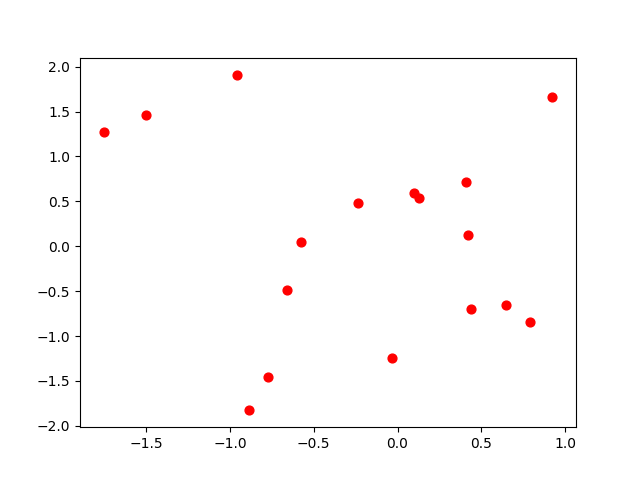

In [90]:
%matplotlib notebook 

importlib.reload(ve)

learning_rate= 1e-3
dense_layers = [100,100]
dense_funcs = ['elu','tanh']
dim_z = 2#20 # latent vector size
dim_out = new_df_train.shape[1]
encoder_input = new_df_train
print(new_df_train[0][:10])
# encoder_input = np.expand_dims(encoder_input,axis=0)
# print("encoder_input {}".format(encoder_input))
z_data = ve.generate_latent_data(learning_rate,dense_layers,dense_funcs,dim_z,dim_out,encoder_input)
print(z_data[:,0],z_data[:,1])
plt.scatter(z_data[:,0],z_data[:,1],marker='o',c='red',s=40)

In [91]:
new_df_train[0][:10]

array([0.33049299, 0.33838875, 0.33915326, 0.33785207, 0.34521115,
       0.34841351, 0.35137537, 0.35387143, 0.35475999, 0.34694776])

In [92]:
%matplotlib notebook 

importlib.reload(ve)

tf.reset_default_graph() 

with tf.Session() as sess:
    learning_rate= 1e-3
    dense_layers = [100,100]
    dense_funcs = ['elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = new_df_train.shape[1]
    
    autoencoder = ve.vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    autoencoder.load()
    
    
    x_PRR = new_df_train
    y_PRR = sess.run(autoencoder.y, feed_dict={autoencoder.x_hat: x_PRR, autoencoder.keep_prob : 1})
    
    print(y_PRR.shape)
    

encoder_dense_layers [100, 100, 2]
elu
tanh
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [100, 100, 120]
tanh
elu
decoder output y:(?, 120)
tanh
elu
INFO:tensorflow:Restoring parameters from ./model/vae.model-1
 [*] Success to read vae.model-1
(17, 120)


<IPython.core.display.Javascript object>


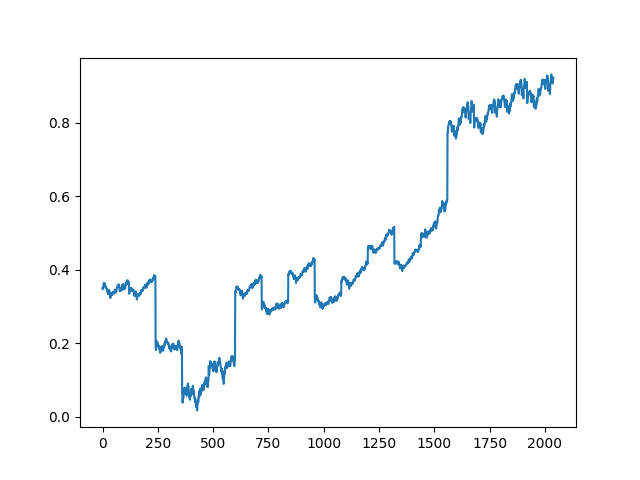

In [93]:
%matplotlib notebook

decode_y = np.array([])
for i in range(y_PRR.shape[0]):
    np_tmp = np.array(y_PRR[i])
    
    decode_y = np.concatenate((decode_y,np_tmp),axis=None)

decode_y.shape
plt.plot(decode_y)

In [94]:

importlib.reload(ve)

learning_rate= 1e-3
dense_layers = [100,100]
dense_funcs = ['elu','tanh']
dim_z = 2#20 # latent vector size
dim_out = new_df_train.shape[1]
# dim_out = np_test.shape[1]
gen_y = ve.generate_stock_data(learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
# gen_y[:10]

encoder_dense_layers [100, 100, 2]
elu
tanh
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [100, 100, 120]
tanh
elu
decoder output y:(?, 120)
tanh
elu
INFO:tensorflow:Restoring parameters from ./model/vae.model-1
 [*] Success to read vae.model-1
sample_z [[-2. -2.]
 [-2. -1.]
 [-2.  0.]
 [-2.  1.]
 [-2.  2.]
 [-1. -2.]
 [-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [-1.  2.]]
gen_y [0.11624096 0.11561222 0.08856893 0.10043579 0.11176652 0.10430229
 0.11907563 0.12947646 0.12551163 0.12748314]


In [70]:
gen_y.shape

(25, 120)

<IPython.core.display.Javascript object>


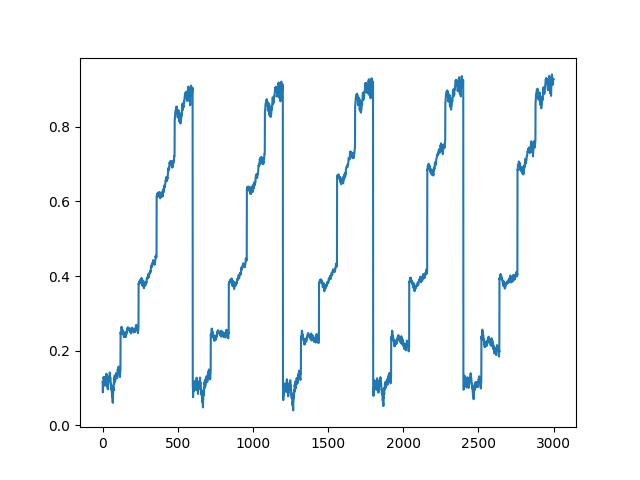

In [95]:
%matplotlib notebook

decode_y = np.array([])
for i in range(gen_y.shape[0]):
    np_tmp = np.array(gen_y[i])
    
    decode_y = np.concatenate((decode_y,np_tmp),axis=None)

decode_y.shape
plt.plot(decode_y)